In [272]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
from typing import List
import time
from tqdm import tqdm
from collections import deque

In [273]:
env = gym.make("CartPole-v1")

In [274]:
def print_observation_space(env):
    print(f"Observation space high: {env.observation_space.high}")
    print(f"Observation space low: {env.observation_space.low}")
    print(f"Number of actions in the action space: {env.action_space.n}")
    
print_observation_space(env)

Observation space high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Observation space low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Number of actions in the action space: 2


In [275]:
def random_seed():
    return random.randint(0, 10000)

seed = random_seed()
print(f"The seed is: {seed}")

The seed is: 6612


Cartpole's state space is continuous, meaning there's infinite states. 

Discretizing the state variable is needed.

TASK 1: Developing the RL agent

In [276]:
def discretiser(state, bins, lower_bounds, upper_bounds):
    bins_list = [np.linspace(lower_bounds[i], upper_bounds[i], bins[i] + 1)[1:-1] for i in range(len(state))]
    return tuple(np.digitize(state[i], bins_list[i]) for i in range(len(state)))

Initializing Q learning

In [277]:
def initialize_q_learning(env, number_of_bins):
    q_matrix = {}
    sum_rewards_episode = []
    
    state_space = np.array(np.meshgrid(*[range(n) for n in number_of_bins])).T.reshape(-1, len(number_of_bins))
    for state in state_space:
        q_matrix[tuple(state)] = np.zeros(env.action_space.n)
    
    return q_matrix, sum_rewards_episode

Choosing the action to perform based on Epsilon-Greedy Strategy

In [278]:
def select_action(state, q_matrix, action_space_size, epsilon, alpha, 
                  number_of_bins, lower_bounds, upper_bounds, 
                  index_episode, number_episodes):
    if index_episode < 500:
        return np.random.choice(action_space_size)  # Pure exploration for first 500 episodes

    # Decrease epsilon over time
    if index_episode > 5000:
        epsilon = 0.999 * epsilon

    if np.random.random() < epsilon:
        return np.random.choice(action_space_size)  # Exploration
    else:
        state_index = discretiser(state, number_of_bins, lower_bounds, upper_bounds)
        if state_index not in q_matrix:
            q_matrix[state_index] = np.zeros(action_space_size)
        return np.random.choice(np.where(q_matrix[state_index] == np.max(q_matrix[state_index]))[0])

In [279]:
def Q_learning(env, alpha, gamma, epsilon, number_episodes, number_of_bins, lower_bounds, upper_bounds):
    q_matrix = {}  # Initialize Q-table
    sum_rewards_episode = []

    for index_episode in tqdm(range(number_episodes), desc="Training Progress"):
        rewards_episode = []
        state_s, _ = env.reset()
        state_s = tuple(state_s)  # Convert to tuple for dictionary key compatibility
        terminal_state = False

        while not terminal_state and len(rewards_episode) < 500:
            state_s_index = discretiser(state_s, number_of_bins, lower_bounds, upper_bounds)

            # Ensure state exists in Q-table
            if state_s_index not in q_matrix:
                q_matrix[state_s_index] = np.zeros(env.action_space.n)

            action_a = select_action(state_s, q_matrix, env.action_space.n, epsilon, alpha, number_of_bins, lower_bounds, upper_bounds, index_episode, number_episodes)

            state_s_prime, reward, terminal_state, truncated, _ = env.step(action_a)
            terminal_state = terminal_state or truncated
            rewards_episode.append(reward)
            state_s_prime = tuple(state_s_prime)  # Convert to tuple to ensure dictionary compatibility

            state_s_prime_index = discretiser(state_s_prime, number_of_bins, lower_bounds, upper_bounds)

            # Ensure next state exists in Q-table
            if state_s_prime_index not in q_matrix:
                q_matrix[state_s_prime_index] = np.zeros(env.action_space.n)

            q_max_prime = np.max(q_matrix[state_s_prime_index]) if not terminal_state else 0
            error = reward + gamma * q_max_prime - q_matrix[state_s_index][action_a]
            q_matrix[state_s_index][action_a] += alpha * error

            state_s = state_s_prime  # Move to next state

        sum_rewards_episode.append(np.sum(rewards_episode))

    return q_matrix, sum_rewards_episode

In [280]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

Testing for optimal hyperparameters


Training with Alpha = 0.01, Epsilon = 0.2


Training Progress: 100%|██████████| 2000/2000 [00:19<00:00, 100.70it/s]



Training with Alpha = 0.05, Epsilon = 0.2


Training Progress: 100%|██████████| 2000/2000 [00:19<00:00, 101.11it/s]



Training with Alpha = 0.1, Epsilon = 0.2


Training Progress: 100%|██████████| 2000/2000 [00:51<00:00, 38.68it/s]



Training with Alpha = 0.2, Epsilon = 0.2


Training Progress: 100%|██████████| 2000/2000 [00:46<00:00, 42.98it/s]



Training with Alpha = 0.3, Epsilon = 0.2


Training Progress: 100%|██████████| 2000/2000 [00:53<00:00, 37.18it/s]



Training with Alpha = 0.5, Epsilon = 0.2


Training Progress: 100%|██████████| 2000/2000 [00:45<00:00, 43.67it/s]


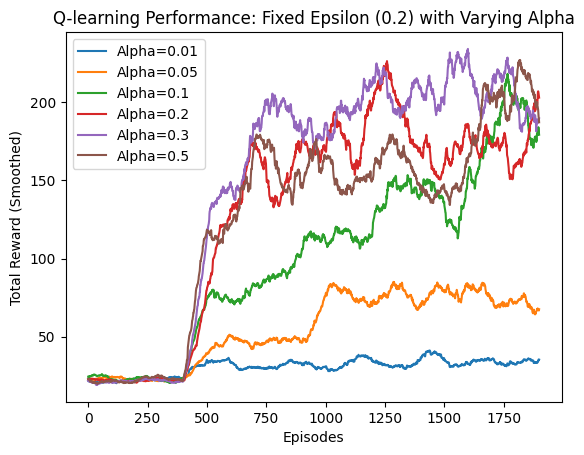


Alpha Experiment Results:
Alpha: 0.01, Avg Reward: 30.59, Std Dev: 21.66, Time: 19.87s
Alpha: 0.05, Avg Reward: 54.85, Std Dev: 46.20, Time: 19.78s
Alpha: 0.1, Avg Reward: 101.17, Std Dev: 92.40, Time: 51.71s
Alpha: 0.2, Avg Reward: 129.74, Std Dev: 108.05, Time: 46.54s
Alpha: 0.3, Avg Reward: 147.89, Std Dev: 122.80, Time: 53.79s
Alpha: 0.5, Avg Reward: 126.05, Std Dev: 104.00, Time: 45.80s

Training with Alpha = 0.2, Epsilon = 0.01


Training Progress: 100%|██████████| 2000/2000 [00:42<00:00, 46.97it/s]



Training with Alpha = 0.2, Epsilon = 0.05


Training Progress: 100%|██████████| 2000/2000 [00:55<00:00, 36.27it/s]



Training with Alpha = 0.2, Epsilon = 0.1


Training Progress: 100%|██████████| 2000/2000 [00:58<00:00, 34.22it/s]



Training with Alpha = 0.2, Epsilon = 0.2


Training Progress: 100%|██████████| 2000/2000 [00:48<00:00, 41.65it/s]



Training with Alpha = 0.2, Epsilon = 0.5


Training Progress: 100%|██████████| 2000/2000 [00:21<00:00, 94.30it/s]



Training with Alpha = 0.2, Epsilon = 1.0


Training Progress: 100%|██████████| 2000/2000 [00:05<00:00, 340.82it/s]


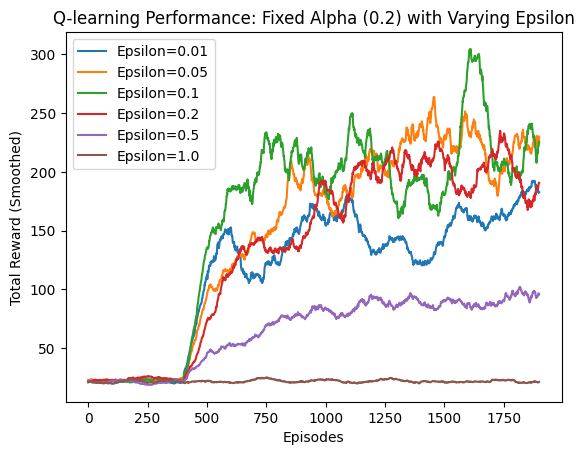


Epsilon Experiment Results:
Epsilon: 0.01, Avg Reward: 115.83, Std Dev: 92.28, Time: 42.58s
Epsilon: 0.05, Avg Reward: 148.21, Std Dev: 126.55, Time: 55.14s
Epsilon: 0.1, Avg Reward: 158.49, Std Dev: 139.85, Time: 58.45s
Epsilon: 0.2, Avg Reward: 134.65, Std Dev: 114.95, Time: 48.02s
Epsilon: 0.5, Avg Reward: 64.99, Std Dev: 50.98, Time: 21.21s
Epsilon: 1.0, Avg Reward: 21.64, Std Dev: 10.89, Time: 5.87s


In [281]:
# Hyperparameters
gamma = 0.99  
number_episodes = 2000  
number_of_bins = [10, 10, 10, 10]
lower_bounds = [-2.4, -2, -0.2, -1.5]
upper_bounds = [2.4, 2, 0.2, 1.5]

env = gym.make("CartPole-v1")

# Experiment 1: Fixed Epsilon, Varying Alpha
alpha_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
epsilon_fixed = 0.2

times_alpha = []
results_alpha = {}
for alpha in alpha_values:
    print(f"\nTraining with Alpha = {alpha}, Epsilon = {epsilon_fixed}")
    start_time = time.time()
    q_matrix, rewards = Q_learning(env, alpha, gamma, epsilon_fixed, number_episodes, number_of_bins, lower_bounds, upper_bounds)
    end_time = time.time()
    
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    times_alpha.append(end_time - start_time)
    results_alpha[alpha] = (avg_reward, std_reward)
    
    plt.plot(moving_average(rewards), label=f"Alpha={alpha}")

plt.xlabel("Episodes")
plt.ylabel("Total Reward (Smoothed)")
plt.title("Q-learning Performance: Fixed Epsilon (0.2) with Varying Alpha")
plt.legend()
plt.show()

print("\nAlpha Experiment Results:")
for alpha, (avg, std) in results_alpha.items():
    print(f"Alpha: {alpha}, Avg Reward: {avg:.2f}, Std Dev: {std:.2f}, Time: {times_alpha[alpha_values.index(alpha)]:.2f}s")

# Experiment 2: Fixed Alpha, Varying Epsilon
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
alpha_fixed = 0.2

times_epsilon = []
results_epsilon = {}
for epsilon in epsilon_values:
    print(f"\nTraining with Alpha = {alpha_fixed}, Epsilon = {epsilon}")
    start_time = time.time()
    q_matrix, rewards = Q_learning(env, alpha_fixed, gamma, epsilon, number_episodes, number_of_bins, lower_bounds, upper_bounds)
    end_time = time.time()
    
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    times_epsilon.append(end_time - start_time)
    results_epsilon[epsilon] = (avg_reward, std_reward)
    
    plt.plot(moving_average(rewards), label=f"Epsilon={epsilon}")

plt.xlabel("Episodes")
plt.ylabel("Total Reward (Smoothed)")
plt.title("Q-learning Performance: Fixed Alpha (0.2) with Varying Epsilon")
plt.legend()
plt.show()

print("\nEpsilon Experiment Results:")
for epsilon, (avg, std) in results_epsilon.items():
    print(f"Epsilon: {epsilon}, Avg Reward: {avg:.2f}, Std Dev: {std:.2f}, Time: {times_epsilon[epsilon_values.index(epsilon)]:.2f}s")


From the testings, I will be using epsilon = 0.1 and alpha = 0.3. 

I will further test this to see if it is optimal

Training Progress: 100%|██████████| 8000/8000 [05:52<00:00, 22.68it/s]


Training Avg Reward: 237.79


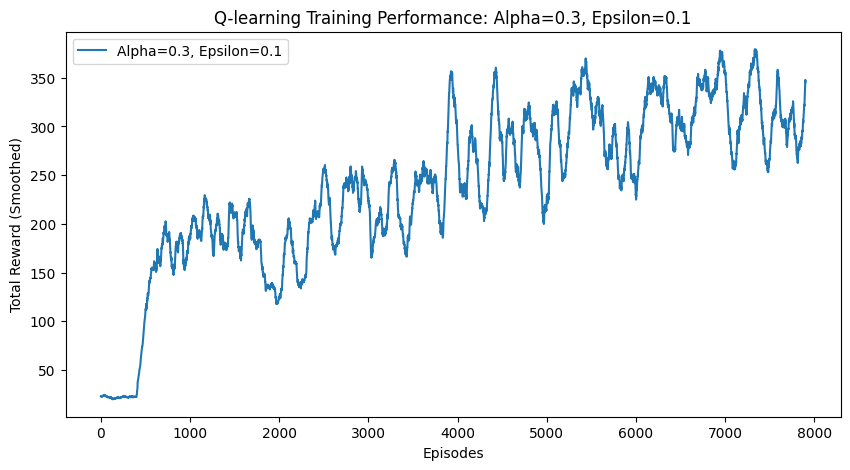

In [282]:
gamma = 0.99  
alpha = 0.3  
epsilon = 0.1
number_episodes = 8000  
number_of_bins = [10, 10, 10, 10]
lower_bounds = [-2.4, -2, -0.2, -1.5]
upper_bounds = [2.4, 2, 0.2, 1.5]

# Initialize environment
env = gym.make("CartPole-v1")

# Run Q-learning
q_matrix, rewards = Q_learning(env, alpha, gamma, epsilon, number_episodes, number_of_bins, lower_bounds, upper_bounds)

# Calculate and print average training reward
avg_reward = np.mean(rewards)
print(f"Training Avg Reward: {avg_reward:.2f}")

# Plot training results with smoothing
plt.figure(figsize=(10, 5))
plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'), label=f"Alpha={alpha}, Epsilon={epsilon}")
plt.xlabel("Episodes")
plt.ylabel("Total Reward (Smoothed)")
plt.title(f"Q-learning Training Performance: Alpha={alpha}, Epsilon={epsilon}")
plt.legend()
plt.show()


In [ ]:
def evaluate_q_learning(q_matrix, env, number_of_bins, lower_bounds, upper_bounds, test_episodes=100, max_steps=500):
    test_rewards = []
    
    for episode in range(test_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        for step in range(max_steps):
            # Discretize the current state
            state_index = discretiser(tuple(state), number_of_bins, lower_bounds, upper_bounds)
            
            # Ensure state exists in Q-table
            if state_index not in q_matrix:
                q_matrix[state_index] = np.zeros(env.action_space.n)
                
            # Choose best action
            action = np.argmax(q_matrix[state_index])
            
            # Take action
            next_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            
            # Update total reward
            total_reward += reward
            
            # Update state for next iteration
            state = next_state
            
            if done:
                break
        
        test_rewards.append(total_reward)
    
    return test_rewards

Evaluating the agent with estimated hyperparamter values

Average cumulative reward: 254.46000000000004
Is my agent good enough? True


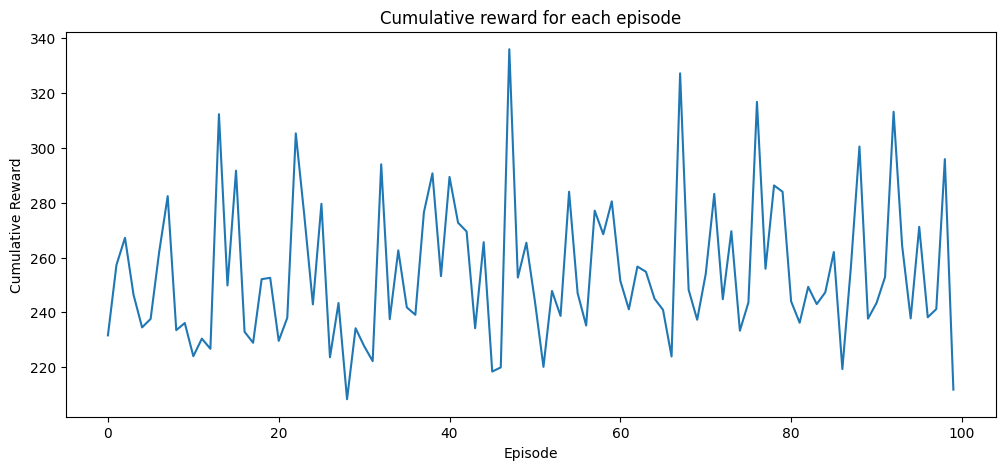

In [ ]:
rewards = evaluate_q_learning(q_matrix, env, number_of_bins, lower_bounds, upper_bounds)
average_reward = np.mean(rewards)

print(f'Average cumulative reward: {average_reward}')
print(f'Is my agent good enough? {average_reward > 195}')

plt.figure(figsize=(12, 5))
plt.plot(rewards)
plt.title('Cumulative reward for each episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.show()

TASK 3: Render one episode played by the agent

In [285]:
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data=f'''
        <video alt="test" autoplay loop controls style="height: 400px;">
        <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
        </video>'''))
    else: 
        print("Could not find video")

In [286]:
def q_learning_policy_agent(state, q_matrix, number_of_bins, lower_bounds, upper_bounds):
    """Select the best action from the trained Q-learning agent."""
    state_index = discretiser(state, number_of_bins, lower_bounds, upper_bounds)
    return np.argmax(q_matrix[state_index])


In [287]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, "./video")

observation, _ = env.reset()

done = False
while not done:
    action = q_learning_policy_agent(observation, q_matrix, number_of_bins, lower_bounds, upper_bounds)
    observation, reward, done, truncated, info = env.step(action)

env.close()
show_video()

MoviePy - Building video c:\Users\yaosh\Documents\SC300-Artificial-Intelligence\video\rl-video-episode-0.mp4.
MoviePy - Writing video c:\Users\yaosh\Documents\SC300-Artificial-Intelligence\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\yaosh\Documents\SC300-Artificial-Intelligence\video\rl-video-episode-0.mp4
